In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE

In [62]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i], t2s[met_i - 1:met_i], M_0s[met_i - 1:met_i]

spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


In [63]:
sigma = 0.01

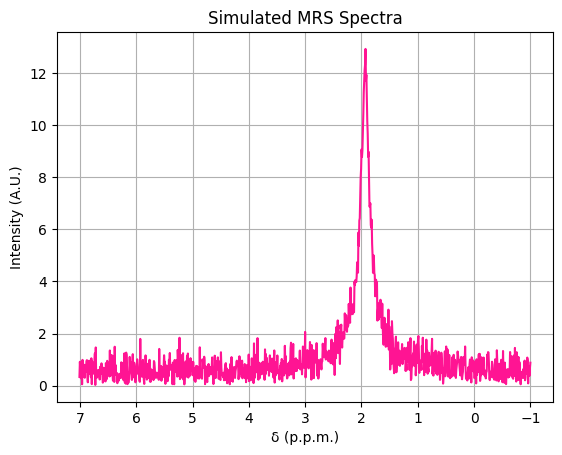

In [64]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

c_sig = pymri.corrupted_snr(sig, 0.0, sigma)
c_freqs, c_sig_fft = pymri.fourier_spectrum( c_sig, dt, B0 )

pymri.plot_chem_shifts( freqs, c_sig_fft, 1.0 )

In [65]:
L = 0.4
noise_threshold = 1e-30

In [66]:
reconstructed_sig, z, r = pymri.filter_sig(c_sig, L, noise_threshold, return_poles_and_res=True)

In [67]:
s0, phi, omega, alpha = pymri.calculate_variables_from_z_and_r(z, r, dt)
t2 = 1/alpha

In [68]:
# n_comp = 10

# sort_arr = np.argsort(s0)
# s0_ = s0[sort_arr]
# phi_ = phi[sort_arr]
# omega_ = omega[sort_arr]
# t2_ = t2[sort_arr]

# s0_ = s0_[s0.size - n_comp:]
# phi_ = phi_[phi.size - n_comp:]
# omega_ = omega_[omega.size - n_comp:]
# t2_ = t2_[t2.size - n_comp:]

# print(t2_.size)

In [69]:
def select_peaks(s0 : np.ndarray,
                 phi : np.ndarray,
                 omega : np.ndarray,
                 t2 : np.ndarray, 
                 percentage : float = 0.1):
    """Calculates the peaks to be individually analysed, based on the highest peak value of `s0`. 
    Peaks below `percentage*highest_peak` will be discarded.
    
    Parameters
    ----------
    s0 : np.ndarray
        Peaks array.
    phi : np.ndarray
        Phases array.
    omega : np.ndarray
        Frequencies array.
    t2 : np.ndarray
        Decaying time T_2 array.
    percentage : float = `0.1`
        The percentage of the peak that will be used to filter. Default is `0.1`."""
    
    sort_arr = np.argsort(s0)

    s0_ = s0[sort_arr]
    phi_ = phi[sort_arr]
    omega_ = omega[sort_arr]
    t2_ = t2[sort_arr]

    peak = s0_[-1]

    s0__ = s0_[s0_ >= percentage*peak]
    phi__ = phi_[s0_ >= percentage*peak]
    omega__ = omega_[s0_ >= percentage*peak]
    t2__ = t2_[s0_ >= percentage*peak]

    n_comp = s0__.size

    return s0__, phi__, omega__, t2__, n_comp


In [70]:
s0_, phi_, omega_, t2_, n_comp = select_peaks(s0, phi, omega, t2, 0.3)

individual_sigs = np.zeros((n_comp, sig.size), dtype=np.complex128)

sig_fft_i = np.zeros((n_comp, sig_fft.size), dtype=np.complex128)
freqs_i = np.zeros((n_comp, freqs.size))

In [71]:
for i in range(n_comp):
    pop = pymri.population(np.array([omega_[i]]), np.array([t2_[i]]), np.array([s0_[i]]), np.array([phi_[i]]))
    individual_sigs[i] = pymri.population_transverse_decay(t0, tn, dt, pop)[0]
    freqs_i[i], sig_fft_i[i] = pymri.fourier_spectrum( individual_sigs[i], dt, B0)
    

In [72]:
final_sig = np.sum(individual_sigs, axis = 0)
freqs_, sig_fft_ = pymri.fourier_spectrum(final_sig, dt, B0)

In [73]:
import matplotlib.colors as mcolors
colors = list(mcolors.CSS4_COLORS)

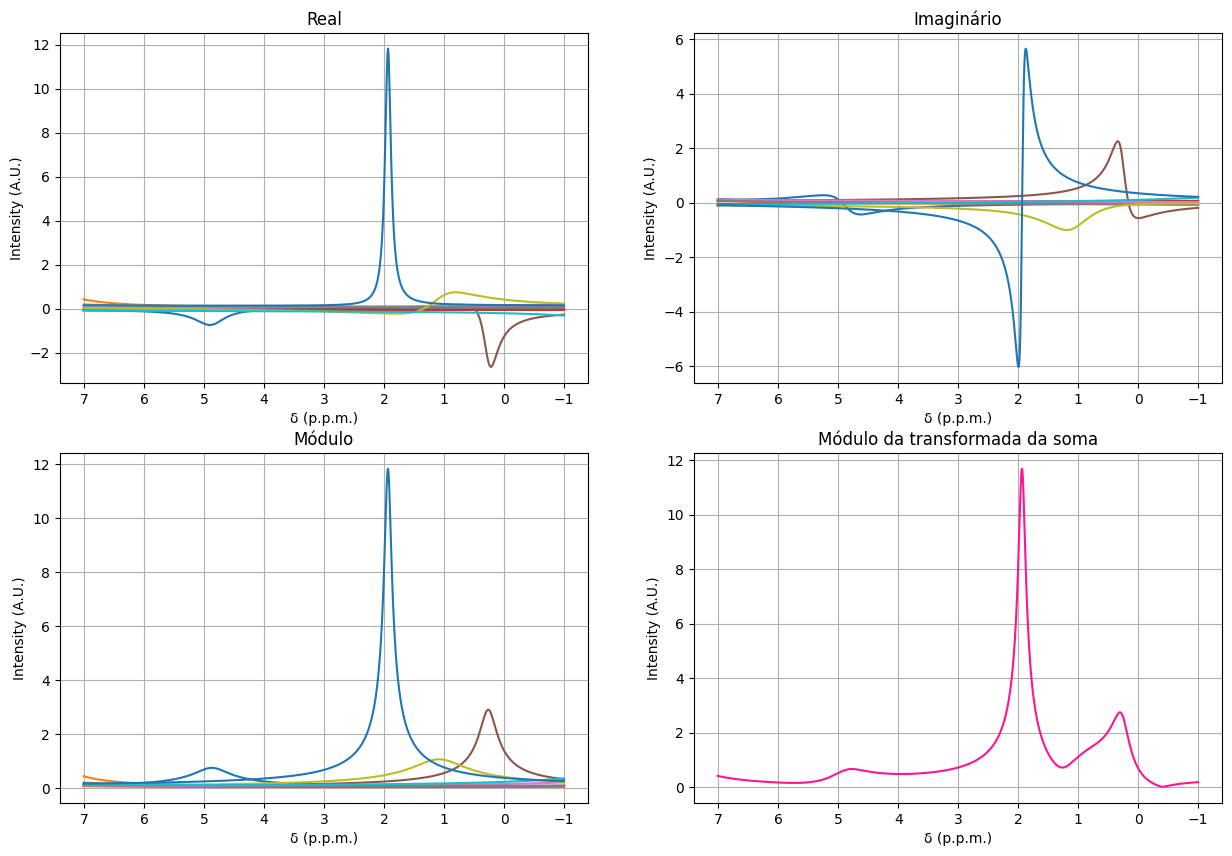

In [74]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
for i in range(n_comp): 
    pymri.plot_chem_shifts(freqs_i[i], sig_fft_i[i], 1.0, c = None, plot_type="real", title= "Real", label=f"{n_comp - i} maior")

plt.subplot(222)
for i in range(n_comp): 
    pymri.plot_chem_shifts(freqs_i[i], sig_fft_i[i], 1.0, c = None, plot_type="imag", title="Imaginário", label=f"{n_comp - i} maior")

plt.subplot(223)
for i in range(n_comp): 
    pymri.plot_chem_shifts(freqs_i[i], sig_fft_i[i], 1.0, c = None, plot_type="abs", title="Módulo", label=f"{n_comp - i} maior")

plt.subplot(224)
pymri.plot_chem_shifts(freqs_, sig_fft_, 1.0, title = "Módulo da transformada da soma", label = "")

## Number of peaks

In [116]:
rerun = True
filename_end = "_2"
folder_name = "files/"

In [117]:
# snrs = np.arange(5.0, 1000.0, 10)
snrs = np.array([500, 750, 1000, 2500, 5000, 7500, 10000, 25000, 50000])
print(snrs.size)
sigmas = pymri.snr_to_sigma(snrs)

9


In [118]:
n_avgs = 3
n_peaks = np.zeros((n_avgs, sigmas.size), dtype=int)
rmse = np.zeros((n_avgs, sigmas.size))

In [119]:
if rerun == True:
    for i in range(n_avgs):
        for j in range(sigmas.size):
            c_sig = pymri.corrupted_snr(sig, 0.0, sigmas[j])

            r_sig, z, r = pymri.filter_sig(c_sig, L, noise_threshold, return_poles_and_res=True, return_full_arrays=True)
            s0_, phi_, omega_, t2_ = pymri.calculate_variables_from_z_and_r(z, r, dt)
            t2_ = 1/t2_
            s0__, phi__, omega__, t2__, n_peaks[i, j] = select_peaks(s0_, phi_, omega_, t2_, 0.05)


            r_sig, t_ = pymri.population_transverse_decay(t0, tn, dt, pymri.population(omega__, t2__, s0__, phi__))

            rmse[i, j] = RMSE(np.abs(c_sig), np.abs(r_sig))

In [120]:
subfolder_name = "spec_comp/"
if rerun == True:
    file = open(folder_name + subfolder_name + "n_peaks" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in snrs) + "\n")
    for i in range(n_avgs):
        file.write(",".join(str(x) for x in n_peaks[i, :]) + "\n")
    file.close()

    file = open(folder_name + subfolder_name + "rmse" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in snrs) + "\n")
    for i in range(n_avgs):
        file.write(",".join(str(x) for x in rmse[i, :]) + "\n")
    file.close()

In [121]:
# If simulation is lost
if(rerun == False):
    file_in = pd.read_csv(folder_name + subfolder_name + "n_peaks" + filename_end + ".csv")

    snrs = file_in.keys().to_numpy(dtype=np.float64)
    n_peaks = file_in.values

    file_in = pd.read_csv(folder_name + subfolder_name + "rmse" + filename_end + ".csv")
    rmse = file_in.values

In [122]:
avg_n_peaks = np.average(n_peaks, axis = 0)
std_n_peaks = np.std(n_peaks, axis = 0)

avg_rmse = np.average(rmse, axis = 0)
std_rmse = np.std(rmse, axis = 0)

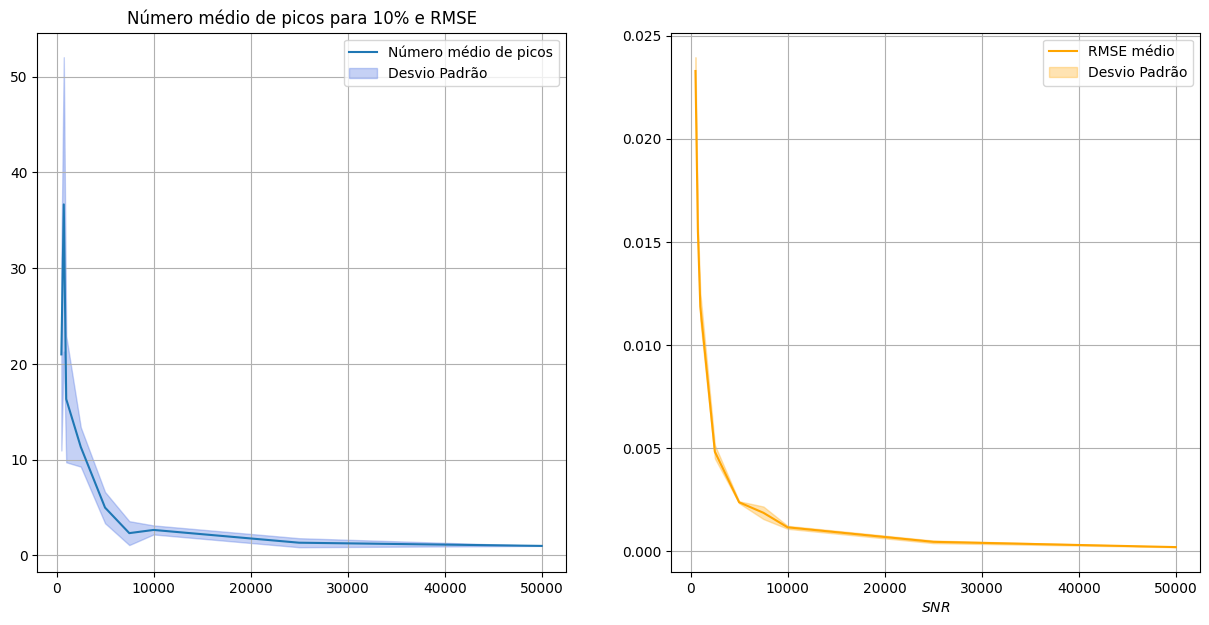

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.title("Número médio de picos para 10% e RMSE")
plt.plot(snrs, avg_n_peaks, label = "Número médio de picos")
plt.fill_between(snrs, avg_n_peaks - std_n_peaks, avg_n_peaks + std_n_peaks, alpha = 0.3, color = "royalblue", label = "Desvio Padrão")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(snrs, avg_rmse, label = "RMSE médio", c = "orange")
plt.fill_between(snrs, avg_rmse - std_rmse, avg_rmse + std_rmse, alpha = 0.3, color = "orange", label = "Desvio Padrão")
plt.xlabel(r"$SNR$")
# plt.ylabel(r"$n$")
plt.legend()
plt.grid()

In [124]:
i = 5

sigma_ = pymri.snr_to_sigma(500)
print(sigma_)

_c_sig = pymri.corrupted_snr(sig, 0.0, sigma_)
_c_freqs, _c_sig_fft = pymri.fourier_spectrum( _c_sig, dt, B0 )

0.015359060873968974


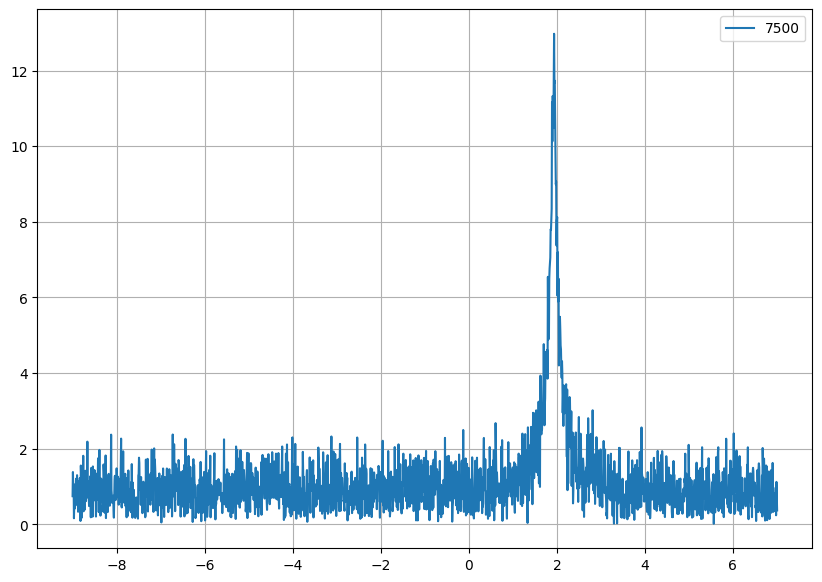

In [125]:
plt.figure(figsize=(10, 7))
plt.plot(_c_freqs, np.abs(_c_sig_fft), label = f"{snrs[i]}")
plt.legend()
plt.grid()